# Predicción de costo de paquetes de viaje para nómades digitales

Desarrollado por: Fernanda Avendaño, Diego Quezada y Kevin Reyes.

# Temas

* Modelos Lineales
* Regularización
* Selección de Características
* Reducción de Dimensionalidad


# Desafío Kaggle 

Una de las paradojas más bizarras e interesantes de esta pandemia ha sido la masificación del concepto nómade digital: una persona, generalmente joven, que se pasa la vida viajando y trabajando de manera remota, a veces desde lugares inusuales y paradisíacos. En palabras de la multitud de personas que durante el último año se han sumado a este estilo de vida, la razón es tan simple como envidiable: "Si tenemos que trabajar en línea, ¿porqué no hacerlo desde un país exótico?".  

Para esta parte del taller, tendrán que constuir un modelo capaz de predecir el precio de un paquete de viajes orientado a nómades digitales a partir de una serie de detalles como el destino o itinerario, los hoteles y comidas incluídas, los vuelos involucrados, etc. 

Para acceder a los detalles del desafío ingrese al siguiente link: https://www.kaggle.com/c/nomades-digitales/



## 1. Importación de librerías

In [1]:
# Fundamentals
import spacy
import json
import datetime as dt
import re
from scipy import stats
import pandas as pd
import numpy as np
import itertools

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import svm
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import ElasticNet

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%load_ext autoreload
%autoreload 2
from styles import *

In [5]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

## 2. Descripción Dataset

Se muestran algunos datos y características generales del dataset:

In [6]:
# Import train and test sets
train = pd.read_csv("./datasets/travel_packages_train.csv")
test = pd.read_csv("./datasets/travel_packages_test.csv")

In [7]:
train.head()

,Unnamed: 0,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,PPPrice
0,7919,North East - Gangtok and Lachung,Deluxe,Gangtok|Lachung|Gangtok,1N Gangtok . 2N Lachung . 1N Gangtok,Gangtok|Lachung|Gangtok,10-01-2022,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,Spicejet|Spicejet,1,3,Singhik View Point | Chungthang | Yumthang Va...,Cancellation any time after making the 1st pay...,284.0
1,982,Spiritual Haridwar from Delhi,Budget,Haridwar,2N Haridwar,Haridwar,21-11-2021,Not Available,Mumbai,Not Available,2,2,Har Ki Pauri,Cancellation any time after making the 1st pay...,129.0
2,3211,Rajasthan Adventure Special with Guided Leopar...,Premium,Jodhpur|Jaisalmer,2N Jodhpur . 2N Jaisalmer,Jodhpur|Jaisalmer,06-08-2021,Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...,New Delhi,IndiGo,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,Cancellation any time after making the 1st pay...,311.0
3,3509,Bhutan 5N - Thimphu(2) Paro(3),Premium,Thimpu|Paro,2N Thimpu . 3N Paro,Thimpu|Paro,27-02-2021,Terma Linca Resort and Spa:4.5|Zhiwa Ling Hote...,New Delhi,Not Available,0,5,Simtokha Dzong | Memorial Chorten | Buddha Do...,Cancellation any time after making the 1st pay...,517.0
4,4820,Splendid North East - Pelling Special (Value a...,Deluxe,Gangtok|Pelling|Darjeeling,2N Gangtok . 1N Pelling . 2N Darjeeling,Gangtok|Pelling|Darjeeling,16-06-2021,Lemon Tree Hotel Gangtok:4.3|The Elgin Mount ...,New Delhi,Go Air,1,3,Changu Lake - Excursion | Baba Mandir | Tashi...,Cancellation any time after making the 1st pay...,336.0


In [8]:
test.head()

,Unnamed: 0,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules
0,7798,A Joyful holiday in Kerala,Standard,Cochin|Munnar|Allepey|Kovalam and Poovar,1N Cochin . 2N Munnar . 1N Allepey . 2N Kovala...,Cochin|Munnar|Allepey|Kovalam and Poovar,17-03-2021,Quality Airport Hotel:4.1|Iceberg Hill Hotel-M...,New Delhi,IndiGo,2,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...
1,1788,Udaipur and Jodhpur Holiday,Premium,Udaipur|Jodhpur,2N Udaipur . 2N Jodhpur,Udaipur|Jodhpur,05-05-2021,Fateh Prakash Palace by HRH Group of Hotels:4....,New Delhi,Not Available,0,5,Lake Pichola | Saheliyon ki Bari | City Palac...,Cancellation any time after making the 1st pay...
2,2084,Golden Triangle - Delhi Agra & Jaipur (Land),Premium,New Delhi|Agra|Jaipur,2N New Delhi . 1N Agra . 2N Jaipur,New Delhi|Agra|Jaipur,19-03-2021,Hilton Garden Inn New Delhi Saket:Five|Tajview...,Mumbai,Not Available,0,5,Convenience Value Pack for Sedan - MMT,Cancellation any time after making the 1st pay...
3,18361,"Holiday in Allepey, Thekkady and Munnar",Standard,Allepey|Thekkady|Munnar,1N Allepey . 1N Thekkady . 2N Munnar,Allepey|Thekkady|Munnar,22-11-2021,"Camelot Hotel, Alleppey- MMT Holidays Special:...",Mumbai,Air India,2,3,Backwaters | Periyar wildlife Sanctuary | Kat...,Cancellation any time after making the 1st pay...
4,13939,Sri Lanka with Galle,Standard,Kandy|Bentota|Galle|Colombo,2N Kandy . 1N Bentota . 1N Galle . 2N Colombo,Kandy|Bentota|Galle|Colombo,26-04-2021,Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:4|Coco...,Mumbai,IndiGo|IndiGo|IndiGo|IndiGo,2,3,Not Available,Cancellation any time after making the 1st pay...


In [9]:
train.describe()

,Unnamed: 0,Flight Stops,Meals,PPPrice
count,15750.000000,15750.000000,15750.000000,15750.000000
mean,10503.896635,0.870222,3.665524,301.367302
std,6062.248551,0.835005,0.893603,117.175722
min,0.000000,0.000000,2.000000,111.000000
25%,5228.500000,0.000000,3.000000,225.000000
50%,10542.000000,1.000000,3.000000,278.000000
75%,15765.250000,2.000000,5.000000,352.000000
max,20999.000000,2.000000,5.000000,1814.000000


In [10]:
test.describe()

,Unnamed: 0,Flight Stops,Meals
count,5250.000000,5250.000000,5250.000000
mean,10486.310095,0.870476,3.665143
std,6063.101313,0.835022,0.893801
min,2.000000,0.000000,2.000000
25%,5307.250000,0.000000,3.000000
50%,10372.000000,1.000000,3.000000
75%,15734.750000,2.000000,5.000000
max,20996.000000,2.000000,5.000000


## 3. Recopilación de datos

Se recopilan datos de fuentes externas a los dataset entregados:

> **distances.json:** Se obtuvieron las distancias entre todos los pares origen-destino hallados en el dataset, a través de la api Distance Matrix de Google maps.  
> **cost_per_km.json:** Se guardaron manualmente los costos promedio por km de cada aerolínea presente en el dataset. En los casos donde no había dato del costo, este fue reemplazado por el costo promedio de las aerolíneas del mismo país.

In [11]:
# Se obtuvieron las distancias con la api distance matrix
def distance_destinations(filename="distances.json"):
    # Read file with distances
    with open(filename, "r") as fp:
        distancias = json.load(fp)

    # Get average distance between two places
    avg_dist = 0
    for origen, destinos in distancias.items():

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            if np.isnan(
                np.nanmean(np.array(list(destinos.values()), dtype=np.float64))
            ):
                continue
            else:
                avg_dist = (
                    avg_dist
                    + np.nanmean(np.array(list(destinos.values()), dtype=np.float64))
                ) / 2

    for origen, destinos in distancias.items():
        # Distancia avg_dist del origen a todos los destinos
        for destino, distancia in destinos.items():
            if distancia == None or np.isnan(distancia):
                distancias[origen][destino] = avg_dist
    return distancias

In [12]:
# diccionario con costos por km
def get_cost_per_km(filename="cost_per_km.json"):
    with open(filename, "r") as fp:
        cost_per_km = json.load(fp)
        return cost_per_km

Fuente: https://www.rome2rio.com/labs/2018-global-flight-price-ranking/

## 4. Exploración de datos

In [13]:
print(
    f'¿Las columnas Destination y Places Coveded son iguales?: {train["Destination"].equals(train["Places Covered"])}'
)

¿Las columnas Destination y Places Coveded son iguales?: True


Se analiza la información contenida en los textos más largos en búsqueda de datos relevantes para la predicción del precio.

In [14]:
# pd.set_option('display.max_colwidth', None)

In [15]:
train["Package Name"].head(5)

0                     North East - Gangtok and Lachung
1                        Spiritual Haridwar from Delhi
2    Rajasthan Adventure Special with Guided Leopar...
3                       Bhutan 5N - Thimphu(2) Paro(3)
4    Splendid North East - Pelling Special (Value a...
Name: Package Name, dtype: object

In [16]:
train["Hotel Details"].head(5)

0    Summit Denzong Hotel & Spa:4.5|Summit Alpine R...
1                                        Not Available
2    Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...
3    Terma Linca Resort and Spa:4.5|Zhiwa Ling Hote...
4    Lemon Tree Hotel  Gangtok:4.3|The Elgin Mount ...
Name: Hotel Details, dtype: object

In [17]:
train["Sightseeing Places Covered"].head(5)

0     Singhik View Point | Chungthang | Yumthang Va...
1                                        Har Ki Pauri 
2     Hanwant Mahal | Candlelight Dinner in Jodhpur...
3     Simtokha Dzong | Memorial Chorten | Buddha Do...
4     Changu Lake - Excursion | Baba Mandir | Tashi...
Name: Sightseeing Places Covered, dtype: object

In [18]:
train["Cancellation Rules"].head(5)

0    Cancellation any time after making the 1st pay...
1    Cancellation any time after making the 1st pay...
2    Cancellation any time after making the 1st pay...
3    Cancellation any time after making the 1st pay...
4    Cancellation any time after making the 1st pay...
Name: Cancellation Rules, dtype: object

Se observa la cantidad de valores únicos por cada variable:

In [19]:
train.nunique()

Unnamed: 0                    15750
Package Name                   2171
Package Type                      5
Destination                     563
Itinerary                       964
Places Covered                  563
Travel Date                     481
Hotel Details                  5158
Start City                        2
Airline                         272
Flight Stops                      3
Meals                             4
Sightseeing Places Covered     1650
Cancellation Rules                8
PPPrice                         701
dtype: int64

1. Se destaca la iguadad de las columnas Destination y Places Covered, además, se observa que la información que aportan es un subconjunto de la información contenida en la columna Itinerary.  
2. Por otro lado, se establece una relación de orden entre los distintos tipos de paquete.  
3. Finalmente, se observa que solo hay dos ciudades de origen presentes en el dataset.

## 5 Preprocesamiento de datos

### 5.1 Data Cleaning

Se lematizan las columnas de textos de interés, además se modifican los nombres de columna para facilitar su referenciación:

In [20]:
def lemmatization(en, text, string=False):
    text = text.lower()
    tokens_to_return = []
    tokens = en(text)  # spacy tokens
    for token in tokens:
        # Is the token a stop word?
        if token.is_stop:
            continue
        # Is the token a number?
        elif token.like_num:
            continue
        # Is the token a whitespace caracter or punctuations?
        elif token.is_space or token.is_punct:
            continue
        # We add the word of interest to a list in its lemmatizated form
        else:
            tokens_to_return.append(token.lemma_)
    if string:
        return " ".join(tokens_to_return)
    return tokens_to_return

In [21]:
def preprocessing(dataset):
    # Fix columns names
    dataset = dataset.rename(columns={"Unnamed: 0": "Index"})
    dataset.columns = dataset.columns.str.lower().str.replace(" ", "_")
    # First time execute:
    # !python -m spacy download en_core_web_sm
    en = spacy.load("en_core_web_sm")
    columns_to_nlp = [
        "package_name",
        "places_covered",
        "hotel_details",
        "sightseeing_places_covered",
        "cancellation_rules",
    ]
    for column in columns_to_nlp:
        dataset[column] = dataset.apply(
            lambda row: lemmatization(en, row[column], string=True), axis=1
        )
    dataset.to_csv("./datasets/dataset_lematizado.csv")

    return dataset

### 5.2 Data transformation

Se crean nuevas variables en base a las variables originales de dataset y datos extraídos de fuentes externas. A continuación se describen algunas de las más importantes:

1. **total_distance:** Distancia total del recorrido considerando el punto de origin, todos los destinos en destinations y el regreso al punto de origen.
2. **cost_per_km:** Costo promedio por km recorrido en base a las aerolíneas presentes en el paquete.
3. **nights:** Cantidad de noches del paquete.
4. **nights_with_spa:** Cantidad de noches del paquete en que se está en un hotel con SPA.
5. **cost_airlines_by_type:** Costo de viaje asociado a la distancia recorrida, costo por km y tipo de paquete.

In [22]:
def count_spa(itinerary, hotel_details, nights):
    # Aproxima la cantidad de noches en un hotel con spa
    try:
        return sum(
            np.array(list(map(int, re.findall("(\d+)N", itinerary))))
            * np.array((list(("spa" in s) for s in hotel_details.lower().split("|"))))
        )
    except:
        return nights / 2


def cost_por_km(row, cost):
    # Calcula la columna de costo total dado los km
    mean_cost_airlines = np.mean(
        np.array([cost[i] for i in row.airline.split("|")], dtype=np.float64)
    )
    return mean_cost_airlines


def weighted_mean_rate(itinerary, hotel_details):
    # Calcula el rate ponderado en base a las noches por hotel
    itinerario = np.array(list(map(int, re.findall("(\d+)N", itinerary))))
    rates = np.array(list(map(float, re.findall("(\d\.\d)", hotel_details))))
    try:
        return sum(itinerario * rates) / sum(itinerario)
    except:
        return np.mean(rates) if len(rates) > 0 else 4.2  # check


def total_distance(row, distances):
    # Calcula distancia total de viaje
    destinations = np.append(
        np.append(row.start_city, np.array(row.destination.split("|"))), row.start_city
    )
    distance = 0
    distances_list = []
    for i in range(len(destinations) - 1):
        current_distance = (
            distances[destinations[i]][destinations[i + 1]]
            if (
                (
                    destinations[i] in distances
                    and destinations[i + 1] in distances[destinations[i]]
                )
            )
            else distances[destinations[i + 1]][destinations[i]]
        )
        distances_list.append(current_distance)
        distance = distance + current_distance
    return distance

In [23]:
def data_transformation(dataset, cost_km, distancias):
    # Transforma la fecha de viaje a datetime
    dataset["date"] = pd.to_datetime(dataset["travel_date"], format="%d-%m-%Y")
    # transforma la fecha a representación ordinal
    dataset["date"] = dataset["date"].map(dt.datetime.toordinal)
    # Se obtiene la cantidad de lugares visitados
    dataset["number_places"] = dataset.apply(
        lambda row: len(row.places_covered.split("|")), axis=1
    )
    # Se obtiene cantidad de lugares turísticos
    dataset["number_sightseeing"] = dataset.apply(
        lambda row: len(row.sightseeing_places_covered.split("|")), axis=1
    )
    # Representación numérica para tipo de paquete
    package_codes = {"Budget": 1, "Standard": 2, "Premium": 3, "Deluxe": 4, "Luxury": 5}
    dataset["package_code"] = dataset.apply(
        lambda row: package_codes[row.package_type], axis=1
    )
    # Se obtiene score de comida en base al tipo de paquete
    dataset["meals_score"] = dataset["meals"] * dataset["package_code"]
    # Se obtiene cantidad de noches
    dataset["nights"] = dataset.apply(
        lambda row: sum(map(int, re.findall("(\d+)N", row.itinerary))), axis=1
    )
    # Se obtiene cantidad de hoteles con spa
    dataset["spa"] = dataset.apply(
        lambda row: int("spa" in row.hotel_details.lower()), axis=1
    )
    # Se obtiene cantidad de noches con spa
    dataset["nights_with_spa"] = dataset.apply(
        lambda row: count_spa(row.itinerary, row.hotel_details, row.nights), axis=1
    )
    # Se obtiene score ponderado de hoteles dentro del paquete
    dataset["hotels_score"] = dataset.apply(
        lambda row: weighted_mean_rate(row.itinerary, row.hotel_details), axis=1
    )
    dataset.hotels_score[dataset.hotels_score == 0] = dataset["hotels_score"][
        dataset["hotels_score"] != 0
    ].mean()
    # Codificacion en one-hot-encoding de ciudad inicial
    dataset = dataset.join(pd.get_dummies(dataset["start_city"]))
    # Codificacion en one-hot-encoding de reglas de cancelacion
    cancellation_rules_code = dict(
        zip(
            dataset["cancellation_rules"].unique(),
            ["a", "b", "c", "d", "e", "f", "g", "h"],
        )
    )
    dataset["cancellation_rule_package"] = dataset.apply(
        lambda row: cancellation_rules_code.get(row.cancellation_rules, "i"), axis=1
    )
    dataset = dataset.join(pd.get_dummies(dataset["cancellation_rule_package"]))
    dataset["i"] = 0
    # Se obtiene distancia total
    dataset["total_distance"] = dataset.apply(
        lambda row: total_distance(row, distancias), axis=1
    )
    # Se obtiene costo por km de viaje
    dataset["cost_per_km"] = dataset.apply(
        lambda row: cost_por_km(row, cost_km), axis=1
    )
    # Se obtiene costo promedio de viaje por aerolinea
    dataset["cost_airlines"] = dataset["total_distance"] * dataset["cost_per_km"]
    # Se obtiene costo promedio de viaje por aerolinea y tipo de paquete
    dataset["cost_airlines_by_type"] = (
        dataset["total_distance"] * dataset["cost_per_km"] * dataset["package_code"]
    )
    # Se codifica fecha considerando formato ciclico
    dataset["sin_date"] = dataset.apply(
        lambda row: np.sin(
            2
            * np.pi
            * (
                int(row.travel_date.split("-")[0])
                + (int(row.travel_date.split("-")[1]) * 30)
            )
            / 365
        ),
        axis=1,
    )
    dataset["cos_date"] = dataset.apply(
        lambda row: np.cos(
            2
            * np.pi
            * (
                int(row.travel_date.split("-")[0])
                + (int(row.travel_date.split("-")[1]) * 30)
            )
            / 365
        ),
        axis=1,
    )

    return dataset

### 5.3 Distribution analysis

Se analizan las distribuciones de las variables independientes y se efectúan transformaciones para llevarlas a distribuciones normales:

In [24]:
# Funciones de transformación para conseguir distribuciones normales
def cubo(x):
    return np.power(x, 3)


def log_cubo(x):
    return np.log(np.power(x, 3))


def test_transformations(
    variable, alpha=0, bins=20, plot=False, only_boxcox=False, title="Histogram"
):
    # Funcion para evaluar transformacion especifica
    # Recibe como input una columna de un dataframe, por ejemplo: df["number_places"]
    if plot:
        # ax = plt.hist(variable, bins=bins, color='b', edgecolor='w')
        ax = sns.displot(variable, bins=bins, color="b", kde=True)
        ax.set_titles(title)

    try:
        variable_boxcox = stats.boxcox(variable, alpha)
        if plot:
            ax = sns.displot(variable_boxcox, bins=bins, color="b", kde=True)
            ax.set_titles(title + " Box cox " + str(alpha))
            # plt.title(title+ ' Box cox '+ str(alpha))
        if only_boxcox:
            return variable_boxcox
    except:
        print("Datos negativos, no es posible aplicar boxcox")

    variable_tr = variable.transform(
        [np.sqrt, np.exp, np.log, np.reciprocal, np.square, cubo]
    )
    if plot:
        variable_tr.hist(bins=20, layout=(3, 3), edgecolor="k", figsize=(10, 8))
        plt.suptitle("Transformed Output")
        plt.show()
    try:
        variable_tr["boxcox"] = variable_boxcox
    except:
        print("")
    return variable_tr

Se descartan las transformaciones a polinomios de grado 2, ya que, provocaron sobreajuste al modelo.

In [25]:
def dist_to_normal(dataset, plot=False):
    # Transformación para conseguir distribución normal en meals score
    dataset["norm_meals_score"] = test_transformations(
        dataset["meals_score"], 0.25, bins=15, plot=plot
    )["sqrt"]
    # Transformación para conseguir distribución normal en nights
    dataset["norm_nights"] = test_transformations(
        dataset["nights"], 0.03, bins=15, plot=plot
    )["boxcox"]
    # Transformación para conseguir distribución normal en total_distance
    dataset["norm_total_distance"] = test_transformations(
        dataset["total_distance"], 0.08, bins=15, plot=plot, only_boxcox=True
    )
    # Transformación para conseguir distribución normal en total_distance
    dataset["norm_cost_airlines"] = test_transformations(
        dataset["cost_airlines"], 0.28, bins=15, plot=plot, only_boxcox=True
    )
    # Transformación para conseguir distribución normal en total_distance
    dataset["norm_cost_airlines_by_type"] = test_transformations(
        dataset["cost_airlines_by_type"],
        0.15,
        bins=15,
        plot=True,
        only_boxcox=True,
        title="cost_airlines_by_type dataset",
    )

    # ADICIONAL Transformación polinomio grado 2
    """
    dataset["number_places_2"] = dataset["number_places"]**2
    dataset["package_code_2"] = dataset["package_code"]**2
    dataset["meals_score_2"] = dataset["meals_score"]**2
    dataset["nights_2"] = dataset["nights"]**2
    dataset["flight_stops_2"] = dataset["flight_stops"]**2
    """
    return dataset

### 5.4 Correlation Analysis

Se analizan las correlaciones entre las variables independientes y la variable dependiente. Luego, se eliminan las variables independientes con baja correlación. Además, se pueden indicar en una lista las variables que generan multicolinealidad en el modelo para que sean eliminadas. En base al análisis de la matriz de correlaciones se decidió que variables formarían parte del modelo final.

In [26]:
def correlation_filter(dataset, umbral=0.2, remover_colinearity=[], non_normalize=[]):
    # Filtro y analisis de variables correlaciones para evitar multicolinearidad
    high_corr = (
        dataset.corr()["ppprice"][np.abs(dataset.corr()["ppprice"]) >= umbral]
    ).index.values
    remover = (
        dataset.corr()["ppprice"][np.abs(dataset.corr()["ppprice"]) < umbral]
    ).index.values
    for deleted in remover:
        high_corr = np.delete(high_corr, np.where(high_corr == deleted))
    dataset_high_corr = dataset[high_corr]

    matrix_corr = dataset_high_corr.corr()
    # matrix_corr.style.background_gradient(cmap='coolwarm')
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        matrix_corr,
        mask=np.zeros_like(matrix_corr, dtype=np.bool),
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        square=True,
        ax=ax,
    )

    non_multicol = high_corr
    # remover = ['norm_cost_airlines','norm_total_distance','b','flight_stops']#probar añadir a la lista
    remover_colinearity = remover_colinearity
    for deleted in remover_colinearity:
        non_multicol = np.delete(non_multicol, np.where(non_multicol == deleted))
    dataset_non_multicol = dataset[non_multicol]

    delete_for_normalizing = non_normalize
    non_multicol_for_normalizing = non_multicol
    for deleted in delete_for_normalizing:
        non_multicol_for_normalizing = np.delete(
            non_multicol_for_normalizing,
            np.where(non_multicol_for_normalizing == deleted),
        )

    # Eliminamos variable dependiente del dataset
    non_multicol = np.delete(non_multicol, np.where(non_multicol == "ppprice"))
    non_multicol_for_normalizing = np.delete(
        non_multicol_for_normalizing,
        np.where(non_multicol_for_normalizing == "ppprice"),
    )

    return non_multicol, non_multicol_for_normalizing

### 5.5 Natural Language Processing

Se aplica procesamiento del lenguaje natural a las columnas de texto de interés para representar las secuencias de texto en vectores. El método utilizado fue CountVectorizer.

In [27]:
def vectorizer(data, vectorizer="CV", ngram_range=(1, 1), max_features=30):
    # Uso de Count Vectorizer o Tfidf vectorizer para transformar palabras del texto en una representacion vectorial para el  entrenamiento
    if vectorizer == "CV":
        data_vectorizer = CountVectorizer(binary=False, ngram_range=ngram_range)
        data_vectorizer.fit(data)
        data_transformed = data_vectorizer.transform(data).toarray()
        return data_vectorizer, data_transformed

    if vectorizer == "Tfidf":
        data_vectorizer = TfidfVectorizer(
            use_idf=False, sublinear_tf=True, max_features=max_features
        )
        data_vectorizer.fit(data)
        data_transformed = data_vectorizer.transform(data).toarray()
        return data_vectorizer, data_transformed

    return None

In [28]:
def nlp_processing(
    train,
    test,
    columns_to_nlp,
    numerical_features,
    ngram_range=(1, 1),
    vect_method="CV",
):
    # Se crean caracteristicas numericas en base a los textos del conjunto de datos
    # Train vectorizer con datos numéricos
    train_num = train[numerical_features]
    vectorizers_nlp = []
    # Se procesan solo las columnas de texto
    for column in columns_to_nlp:
        # Vectorizacion de palabras
        v, column_nlp = vectorizer(
            train[column], vectorizer=vect_method, ngram_range=ngram_range
        )
        vectorizers_nlp.append(v)
        df_package_name_vect = pd.DataFrame(column_nlp)
        # Se anade nueva columna
        train_num = pd.concat(
            [train_num, df_package_name_vect], axis=1, ignore_index=False
        )

    test_num = test[numerical_features]
    # Se procesa conjunto de pruebas
    for i in range(len(columns_to_nlp)):
        columna_vect = vectorizers_nlp[i].transform(test[columns_to_nlp[i]]).toarray()
        df_package_name_vect = pd.DataFrame(columna_vect)
        test_num = pd.concat(
            [test_num, df_package_name_vect], axis=1, ignore_index=False
        )

    # Atributos numéricos, data set listos para entrenar
    return train_num, test_num

### 5.6 Normalization

Se procede a normalizar las variables numéricas mediante el método StandardScaler de sklearn.

In [29]:
def get_normalizer(dataset, columns_to_normalize):
    # Normalize data
    # columns_to_normalize = ['package_code','meals_score','nights', 'nights_with_spa', 'hotels_score','meals','flight_stops','total_distance']
    ct = ColumnTransformer(
        [("standardscal", StandardScaler(), columns_to_normalize)],
        remainder="passthrough",
    )

    return ct.fit(dataset)

### 5.7 Other attribute engineering tools

Otras herramientas probadas en todo el proceso del desafío, calcular las **características polinomiales** se descarta luego de aplicar NLP a las columnas de texto, ya que genera dataset con muchas columnas provocando sobreajuste. **Select_best_features** también se descarta al incorporar NLP, ya que, toma un tiempo considerable de computación, además de no generar grandes mejoras en el modelo (inclusive lo empeora).  
El método **VarianceThreshold** fue utilizado he introdujo mejoras al modelo eliminando aquellas variables con muy poca varianza, es decir, bajo aporte de información al modelo.

In [30]:
def getter_polynomial_features(dataset, degree=2):
    # Ejemplo, para un atributo x, con grado 3 genera: x , x^2 , x^3
    poly_features = PolynomialFeatures(degree=degree).fit(dataset)
    return poly_features

In [31]:
def getter_delete_low_variance(dataset, umbral=0):
    # Eliminacion de variables con bajo aporte de informacion (baja varianza)
    return VarianceThreshold(threshold=umbral).fit(dataset)

In [32]:
def getter_select_best_features(X, y, method="select_k", k=15, direction="forward"):
    # Funcion para seleccionar mejores variables para el modelo
    if method == "sfs":
        lasso_cv_poly = LassoCV().fit(X, y)
        # Algoritmo greedy que selecciona cada vez la variable que más aporta a la predicción
        selector = SequentialFeatureSelector(
            lasso_cv_poly, n_features_to_select=k, direction=direction
        ).fit(X, y)
    elif method == "select_k":
        # Selecciona las mejores k características en base a una métrica de información
        select_method = [f_regression, mutual_info_regression][0]
        selector = SelectKBest(select_method, k=k).fit(X, y)

    return selector

## 6. Model evaluation

Función para evaluar el modelo en el error de validación y de entrenamiento (se utilizó para verificar sobre ajuste). Además, genera el submit para kaggle en caso de que se le indique:

In [33]:
def evaluar_modelo(
    X_train,
    y_train,
    model,
    X_val=None,
    y_val=None,
    X_test=None,
    test=None,
    params=dict(),
    submit=False,
):
    # Funcion para evaluar el modelo
    if submit:
        modelo = model(**params)
        modelo = modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        test_submit = test
        test_submit["ppprice"] = y_pred
        test_submit = test_submit[["index", "ppprice"]]
        test_submit = test_submit.rename(
            columns={"index": "Index", "ppprice": "PPPrice"}
        )
        test_submit.to_csv("./submissions/submission-to-kaggle.csv", index=False)
        return modelo
    else:
        modelo = model(**params)
        modelo = modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_val)
        y_pred_train = modelo.predict(X_train)
        print(f"Error de validación: {mean_absolute_percentage_error(y_val,y_pred)}")
        print(
            f"Error de entrenamiento: {mean_absolute_percentage_error(y_train,y_pred_train)}"
        )
        return modelo

## 7. Pipeline

Pipeline donde se ejecuta todo el proceso descrito previamente. Se establecen condicionales para evitar repetir el preprocesamiento en aquellos puntos donde no hay cambio, a través de un sistema de "cache" de datasets preprocesados hasta un cierto punto del proceso. Lo anterior se realiza a través del parámetro repeat_from, que permita preprocesar desde cierto punto en adelante, por ejemplo, si se utiliza repeat_from=5, se cargará el dataset preprocesado hasta la aplicación del procesamiento de lenguaje natural y se realizará nuevamente el proceso de normalización de los datos. 
  
Finalmente, se diseña un algoritmo para evaluar parámetros en una grilla dependiendo del algoritmo utilizado y sus parámetros asociados:

> El caché está disponible en el siguiente [link](https://drive.google.com/drive/folders/1-15t7bsbLnrZrJedUm2tsF5QZYhW9j5O?usp=sharing)

In [34]:
def pipeline(
    train,
    test,
    repeat_from=2,
    poly=False,
    lv=False,
    sb=False,
    corr=False,
    all_models=False,
    pair_plot=False,
    plot_normal=False,
    remove_outliers=False,
):
    # Flujo de ejecucion de funciones previamente descritas
    # repeat from permite saltarse pasos de procesamiento ya realizados, ya que guarda los dataset históricos
    cache_dir = "./datasets/cache/"
    if repeat_from > 1:
        train_pp = pd.read_csv(cache_dir + "train_pp.csv")
        test_pp = pd.read_csv(cache_dir + "test_pp.csv")
    elif repeat_from <= 1:
        train_pp = preprocessing(train)
        test_pp = preprocessing(test)
        train_pp.to_csv(cache_dir + "train_pp.csv", index=False)
        test_pp.to_csv(cache_dir + "test_pp.csv", index=False)

    cost = get_cost_per_km()
    distancias = distance_destinations()

    if repeat_from == 3:
        train_dt = pd.read_csv(cache_dir + "train_dt.csv")
        test_dt = pd.read_csv(cache_dir + "test_dt.csv")
    elif repeat_from <= 2:
        train_dt = data_transformation(train_pp, cost, distancias)
        test_dt = data_transformation(test_pp, cost, distancias)
        train_dt.to_csv(cache_dir + "train_dt.csv", index=False)
        test_dt.to_csv(cache_dir + "test_dt.csv", index=False)

    if plot_normal:
        print("-----------------------------------")
        print("1- Ejemplo de transformación a distribución normal")
        print(
            "Variable costo por km recorridos para cada aerolinea llevado a distribución normal"
        )
        train_dt = pd.read_csv(cache_dir + "train_dt.csv")
        test_transformations(
            train_dt["cost_airlines_by_type"],
            0.15,
            bins=15,
            plot=True,
            only_boxcox=True,
            title="cost_airlines_by_type dataset",
        )

    if repeat_from == 4:
        train_dn = pd.read_csv(cache_dir + "train_dn.csv")
        test_dn = pd.read_csv(cache_dir + "test_dn.csv")
    elif repeat_from <= 3:
        train_dn = dist_to_normal(train_dt, plot=False)
        test_dn = dist_to_normal(test_dt, plot=False)
        train_dn.to_csv(cache_dir + "train_dn.csv", index=False)
        test_dn.to_csv(cache_dir + "test_dn.csv", index=False)

    if corr:
        print("-----------------------------------")
        print("2- Matriz de correlaciones para detectar multicolinearidad")
        train_dn = pd.read_csv(cache_dir + "train_dn.csv")
        non_multi_col, non_multicol_for_normalizing = correlation_filter(
            train_dn, umbral=0.2, remover_colinearity=[], non_normalize=[]
        )

    # columns_to_nlp = ['sightseeing_places_covered','hotel_details']
    columns_to_nlp = [
        "sightseeing_places_covered",
        "hotel_details",
        "airline",
        "itinerary",
    ]  # mejores resultados
    # numerical_features = ['date','package_code',
    #                    'meals_score','spa','nights','nights_with_spa','hotels_score',
    #                    'b','c','New Delhi',
    #                    'meals','flight_stops','total_distance',
    #                    'norm_total_distance','norm_meals_score','norm_nights',
    #                    'norm_cost_airlines','norm_cost_airlines_by_type']
    numerical_features = [
        "package_code",
        "hotels_score",
        "meals",
        "norm_nights",
        "norm_cost_airlines_by_type",
        "a",
        "b",
        "c",
    ]  # mejores resultados

    if pair_plot:
        print("-----------------------------------")
        print("3- Distribuciones y correlaciones entre variables numéricas")

        numerical_features_ppp = [
            "package_code",
            "hotels_score",
            "meals",
            "norm_meals_score",
            "norm_nights",
            "norm_cost_airlines_by_type",
            "ppprice",
        ]
        pairplot = sns.pairplot(train_dn[numerical_features_ppp])
        plt.show()

    if repeat_from <= 4 and remove_outliers:
        index_to_remove = train_dn[train_dn.ppprice > 500].index
        train_dn = train_dn.drop(index_to_remove)
        train_pp = train_pp.drop(index_to_remove)
        train_dn.to_csv(cache_dir + "train_dn.csv", index=False)
        train_pp.to_csv(cache_dir + "train_pp_outliers.csv", index=False)

    if repeat_from == 5:
        train_nlp = pd.read_csv(cache_dir + "train_nlp.csv")
        test_nlp = pd.read_csv(cache_dir + "test_nlp.csv")
    elif repeat_from <= 4:
        train_nlp, test_nlp = nlp_processing(
            train_dn,
            test_dn,
            columns_to_nlp=columns_to_nlp,
            numerical_features=numerical_features,
            ngram_range=(1, 2),
            vect_method="CV",
        )
        train_nlp.to_csv(cache_dir + "train_nlp.csv", index=False)
        test_nlp.to_csv(cache_dir + "test_nlp.csv", index=False)

    # columns_to_normalize = ['date','package_code',
    #                    'meals_score','nights','nights_with_spa','hotels_score',
    #                    'meals','flight_stops','total_distance',
    #                    'norm_total_distance','norm_meals_score','norm_nights',
    #                    'norm_cost_airlines','norm_cost_airlines_by_type']
    columns_to_normalize = [
        "package_code",
        "hotels_score",
        "meals",
        "norm_nights",
        "norm_cost_airlines_by_type",
    ]  # mejores resultados

    if repeat_from == 6:
        train_norm = pd.read_csv(cache_dir + "train_norm.csv")
        test_norm = pd.read_csv(cache_dir + "test_norm.csv")

    elif repeat_from <= 5:
        normalizer = get_normalizer(train_nlp, columns_to_normalize)
        train_norm = normalizer.transform(train_nlp)
        test_norm = normalizer.transform(test_nlp)
        train_norm = pd.DataFrame(
            data=train_norm[0:, 0:],
            index=[i for i in range(train_norm.shape[0])],
            columns=["f" + str(i) for i in range(train_norm.shape[1])],
        )
        test_norm = pd.DataFrame(
            data=test_norm[0:, 0:],
            index=[i for i in range(test_norm.shape[0])],
            columns=["f" + str(i) for i in range(test_norm.shape[1])],
        )
        train_norm.to_csv(cache_dir + "train_norm.csv", index=False)
        test_norm.to_csv(cache_dir + "test_norm.csv", index=False)

    if lv:
        low_var = getter_delete_low_variance(train_norm, umbral=0.0005)
        train_norm = low_var.transform(train_norm)
        test_norm = low_var.transform(test_norm)

    if poly:
        poly_getter = getter_polynomial_features(train_norm, degree=2)
        train_norm = poly_getter.transform(train_norm)
        test_norm = poly_getter.transform(test_norm)

    if sb:
        select_best = getter_select_best_features(
            train_norm,
            train_pp["ppprice"],
            method="select_k",
            k=15,
            direction="forward",
        )
        train_norm = select_best.transform(train_norm)
        test_norm = select_best.transform(test_norm)

    train_dn = pd.read_csv(cache_dir + "train_dn.csv")
    X_train, X_val, y_train, y_val = train_test_split(
        train_norm, train_dn["ppprice"], test_size=0.3, random_state=42
    )

    models = {
        "ridge": Ridge,
        "sgd": SGDRegressor,
        "lr": LinearRegression,
        "lasso": linear_model.Lasso,
        "bayes_ridge": linear_model.BayesianRidge,
        "ridge_cv": linear_model.RidgeCV,
        "lasso_lars": linear_model.LassoLars,
        "elastic": ElasticNet,
    }

    if all_models:
        # alpha = np.linspace(-5,5,6) # ridge, lasso,elastic,sgd,bayes ridge
        # l1_ratio = np.linspace(0,1,5) # elastic [0-1]
        # compute_score= [True,False] # bayes
        # penalty = ['l2','l1','elasticnet']# sgd
        grid = {
            "alpha": np.linspace(0.0001, 5, 4),
            "l1_ratio": np.linspace(0, 1, 4),
            "compute_score": [True, False],
            "penalty": ["l2", "l1", "elasticnet"],
            "normalize": [False],
            "max_iter": [10000],
            "early_stopping": [True],
        }
        param_per_model = {
            "ridge": ["alpha"],
            "lr": ["normalize"],
            "lasso": ["alpha"],
            "bayes_ridge": ["compute_score", "alpha"],
            "ridge_cv": ["alpha"],
            "lasso_lars": ["alpha"],
            "elastic": ["alpha", "l1_ratio"],
            "sgd": ["penalty", "alpha", "l1_ratio", "max_iter", "early_stopping"],
        }

        grid_per_model = {}

        for model_params, params in param_per_model.items():
            lista_params = []
            for param in params:
                lista_params.append(grid[param])
            combinations = list(itertools.product(*lista_params))
            grid_per_model[model_params] = [
                dict(zip(params, combination)) for combination in combinations
            ]

        for name, model in models.items():
            for params in grid_per_model[name]:
                print("-----------------------------------")
                print(f"Evaluando modelo: {name}")
                print(f"Con los siguientes parámetros: {params}")
                evaluar_modelo(
                    X_train,
                    y_train,
                    model=models[name],
                    X_val=X_val,
                    y_val=y_val,
                    X_test=None,
                    params=params,
                    submit=False,
                )
                print("-----------------------------------")
    # params = {"alpha":0.00001,"penalty":"elasticnet","l1_ratio":0.05,"max_iter":60000,"early_stopping":True} # SGD
    params = {"alpha": 5}  # ridge
    # params = {"alpha:"5} # Mejor resultado
    # params = {"compute_score":True} #bayes
    # submit modelo Ridge mejor resultado
    train_pp = pd.read_csv(cache_dir + "train_pp_outliers.csv")
    # evaluar_modelo(train_norm,train_pp["ppprice"],model=models["ridge"],X_test=test_norm,test=test_pp,params=params,submit=True)
    return evaluar_modelo(
        X_train,
        y_train,
        model=models["ridge"],
        X_val=X_val,
        y_val=y_val,
        X_test=None,
        params=params,
        submit=False,
    )

Utilizamos repeat from para evitar tener que realizar el procesamiento de los datos de principio a fin. Si por ejemplo todo el procesamiento hasta antes del análisis de procesamiento de lenguaje natural permanece igual, entonces utilizamos repeat_from=4 para cargar el dataset directamente.

Al correr la pipeline, se observan gráficos resultantes de algunos de sus procesos. (Por un motivo que desconocemos los prints se realizan todos juntos al principio y posterior a ello se imprimen los gráficos, sin embargo, en el código estaban ordenados cada gráfico con su print como título.

**Si es primera vez que se ejecuta el código y no se tienen los datasets de preprocesamiento en /datasets/cache/, entonces se debe utilizar repeat_from=1 al llamar la pipeline. Luego de ejecutar un vez se recomienda ejecutar con repeat_from más altos para evitar correr todo el código nuevamente**

-----------------------------------
1- Ejemplo de transformación a distribución normal
Variable costo por km recorridos para cada aerolinea llevado a distribución normal
-----------------------------------
2- Matriz de correlaciones para detectar multicolinearidad
-----------------------------------
3- Distribuciones y correlaciones entre variables numéricas


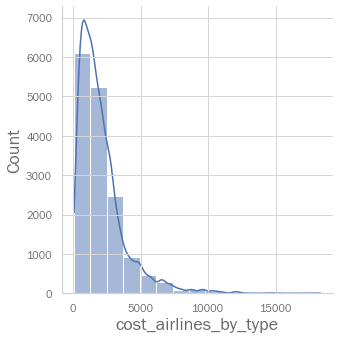

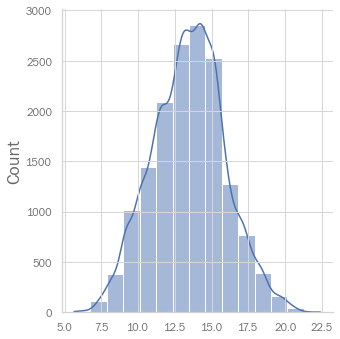

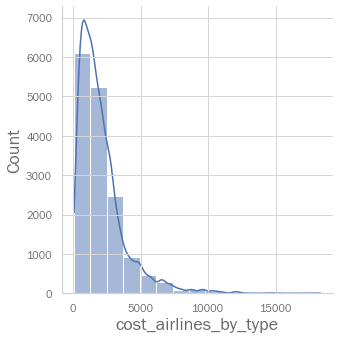

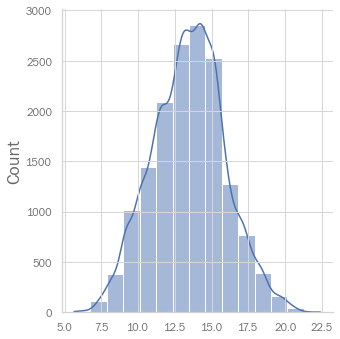

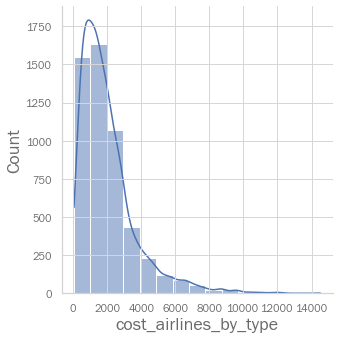

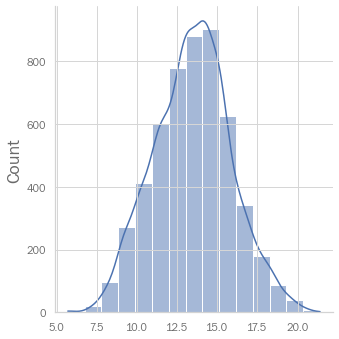

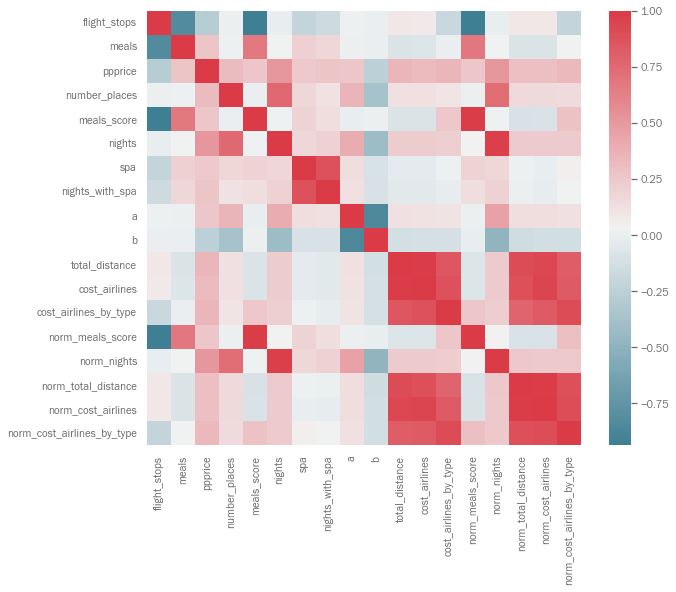

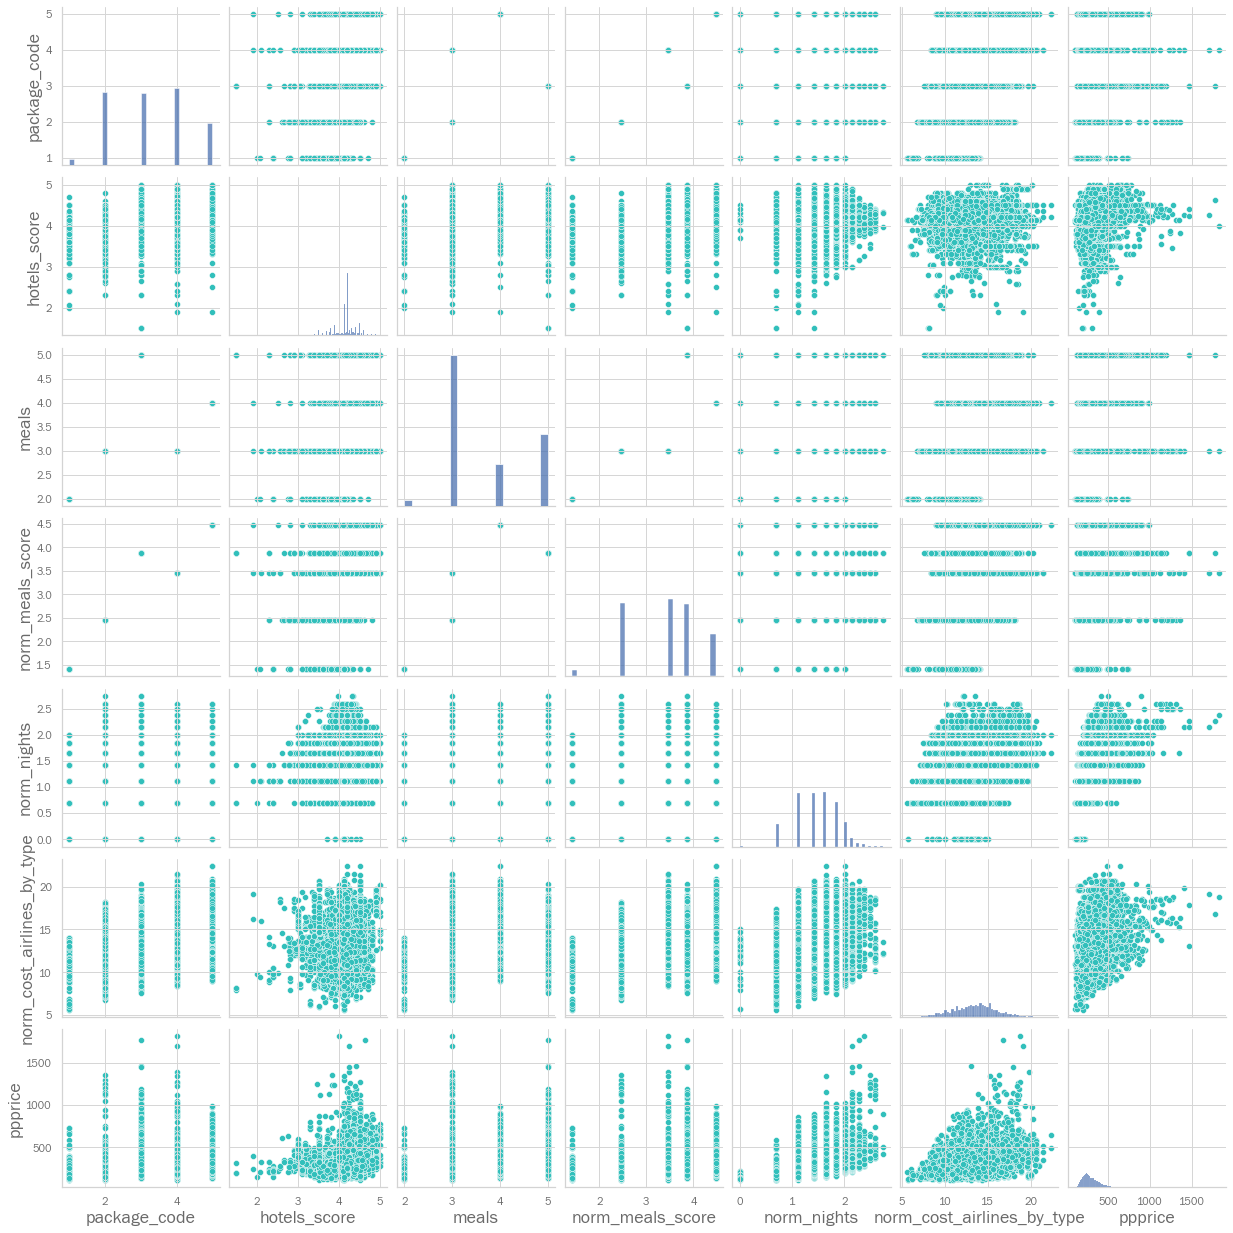

C:\ProgramData\Miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Error de validación: 0.1002294335607255
Error de entrenamiento: 0.08036042011704417


Ridge(alpha=5)

In [37]:
# CUIDADO: Al utilizar repeat_from 1 se volverán a calcular los lemmas lo que toma bastante tiempo.
pipeline(
    train,
    test,
    repeat_from=3,
    poly=False,
    lv=True,
    sb=False,
    corr=True,
    all_models=False,
    pair_plot=True,
    plot_normal=True,
    remove_outliers=False,
)

**El error fue medido con métrica MAPE**

## 8. Submit

El archivo submission_to_kaggle.csv es generado automáticamente en la pipeline y está ubicado en la carpeta submissions.

## 9. Conclusiones

1. Al trabajar con modelos simples se experimenta la importancia de la ingeniería de características para obtener buenos resultados ya que, la diferencia de rendimiento entre distintos modelos lineales es ínfima, por lo que, las grandes mejoras en el desempeño están totalmente correlacionadas con los atributos que se incluyen en el modelo.
2. El hecho de eliminar variables para evitar la multicolinearidad entre las variables independientes no siempre provoca una mejora en el desempeño de la regresión lineal.
3. A medida que la cantidad de atributos aumenta, el impacto del regularizador en el desempeño de los modelos es más significativo.
4. Al realizar un proceso de creación de nuevas características se debe tener siempre en cuenta que se podría estar introduciendo multicolinealidad al modelo, por ejemplo, cuando aplicamos one-hot-encoding, introducimos directamente una multicolinealidad al modelo, la que se puede resolver eliminando una de las variables del one-hot-encoding.